In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))



df = pd.read_csv(os.path.join(os.getcwd(), "../../data/total_4am.csv"), index_col=0)

df

,day_starting_at_4am,open,high,low,close,volume_krw,volume_market
0,2021-03-31 04:00:00,70913000.0,72000000.0,70838000.0,71672000.0,8.072377e+10,1128.289061
1,2021-04-01 04:00:00,71619000.0,73117000.0,70670000.0,72997000.0,6.635804e+11,9202.724442
2,2021-04-02 04:00:00,72997000.0,74400000.0,71841000.0,73791000.0,6.514828e+11,8859.982312
3,2021-04-03 04:00:00,73790000.0,75703000.0,73100000.0,74815000.0,5.678623e+11,7604.545110
4,2021-04-04 04:00:00,74815000.0,75100000.0,71570000.0,73090000.0,6.160404e+11,8423.984650
...,...,...,...,...,...,...,...
1232,2024-08-14 04:00:00,84725000.0,85950000.0,82483000.0,82732000.0,3.119777e+11,3703.563056
1233,2024-08-15 04:00:00,82732000.0,83555000.0,81048000.0,81437000.0,2.546273e+11,3093.291193
1234,2024-08-16 04:00:00,81436000.0,83040000.0,79500000.0,82912000.0,2.868403e+11,3534.627568
1235,2024-08-17 04:00:00,82911000.0,83400000.0,82042000.0,82766000.0,9.552768e+10,1156.014190


In [2]:
import pandas as pd
import numpy as np
from performance import get_performance

# Assuming the dataframe is named df
# Calculate the price change
df['price_change'] = df['close'].diff()

# Calculate the gains and losses
df['gain'] = np.where(df['price_change'] > 0, df['price_change'], 0)
df['loss'] = np.where(df['price_change'] < 0, -df['price_change'], 0)

# Calculate the average gain and average loss
window_length = 14
df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=1).mean()
df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=1).mean()

# Calculate the RS (Relative Strength) and RSI
df['rs'] = df['avg_gain'] / df['avg_loss']
df['rsi'] = 100 - (100 / (1 + df['rs']))

# Implement RSI strategy for long positions only
df['signal'] = 0  # Default to no position
for i in range(1, len(df)):
    # 매수 조건
    if (df.loc[i, 'rsi'] >= 30) and (df.loc[i-1, 'rsi'] < 30):
        df.loc[i, 'signal'] = 1
    # 매도 조건
    elif (df.loc[i, 'rsi'] <= 70) and (df.loc[i-1, 'rsi'] > 70):
        df.loc[i, 'signal'] = -1

# # Manage positions with stop loss, take profit, and sell signal
# df['position'] = 0
# df['entry_price'] = np.nan
# df['exit_price'] = np.nan
# holding_position = False

# for i in range(1, len(df)):
#     if df['signal'].iloc[i] == 1 and not holding_position:
#         # Enter position
#         df.loc[i, 'position'] = 1
#         df.loc[i, 'entry_price'] = df.loc[i, 'close']
#         holding_position = True
#     elif holding_position:
#         # Calculate percentage change since entry
#         entry_price = df['entry_price'].iloc[i-1]
#         current_price = df['close'].iloc[i]
#         percent_change = (current_price - entry_price) / entry_price * 100

#         if df['signal'].iloc[i] == -1:  # Sell signal condition
#             # print(f"cond1 on{i}")
#             df.loc[i, 'position'] = 0
#             df.loc[i, 'exit_price'] = current_price
#             holding_position = False
#         elif percent_change <= -5:  # Stop loss condition
#             # print(f"cond2 on{i}")
#             df.loc[i, 'position'] = 0
#             df.loc[i, 'exit_price'] = current_price
#             holding_position = False
#         # elif percent_change >= 30:  # Take profit condition
#         #     print(f"cond3 on{i}")
#         #     df['position'].iloc[i] = 0
#         #     df['exit_price'].iloc[i] = current_price
#         #     holding_position = False
#         else:
#             # Continue holding the position if no sell conditions are met
#             # df['position'].iloc[i] = df['position'].iloc[i-1]
#             df.loc[i, 'position'] = df.loc[i-1, 'position']
#             # df['entry_price'].iloc[i] = df['entry_price'].iloc[i-1]
#             df.loc[i, 'entry_price'] = df.loc[i-1, 'entry_price']
#     else:
#         # No signal and no position
#         # df['position'].iloc[i] = df['position'].iloc[i-1]
#         df.loc[i, 'position'] = df.loc[i-1, 'position']

# Manage positions with stop loss, take profit, and sell signal
df['position'] = 0
df['highest_price'] = np.nan
df['exit_price'] = np.nan
holding_position = False

for i in range(1, len(df)):
    if df['signal'].iloc[i] == 1 and not holding_position:
        # Enter position
        df.loc[i, 'position'] = 1
        df.loc[i, 'highest_price'] = df.loc[i, 'close']
        holding_position = True
    elif holding_position:
        # Calculate percentage change since entry
        # df['highest_price'].iloc[i] = max(df['highest_price'].iloc[i-1], df['close'].iloc[i])
        df.loc[i, 'highest_price'] = max(df.loc[i-1, 'highest_price'], df.loc[i-1, 'close'])
        highest_price = df['highest_price'].iloc[i]
        current_price = df['close'].iloc[i]
        percent_change = (current_price - highest_price) / highest_price * 100

        if df['signal'].iloc[i] == -1:  # Sell signal condition
            # print(f"cond1 on{i}")
            df.loc[i, 'position'] = 0
            df.loc[i, 'exit_price'] = current_price
            holding_position = False
        elif percent_change <= -5:  # Stop loss condition
            # print(f"cond2 on{i}")
            df.loc[i, 'position'] = 0
            df.loc[i, 'exit_price'] = current_price
            holding_position = False
        else:
            # Continue holding the position if no sell conditions are met
            df.loc[i, 'position'] = df.loc[i-1, 'position']

    else:
        # No signal and no position
        # df['position'].iloc[i] = df['position'].iloc[i-1]
        df.loc[i, 'position'] = df.loc[i-1, 'position']
        
# Calculate the strategy returns (only when in a long position)
df['strategy_returns'] = df['position'].shift(1) * df['close'].pct_change()
df['strategy_returns2'] = df['strategy_returns']
        
for i in range(1, len(df)):
    buy_price = df.loc[i-1, "close"]
    buy_price_copy = buy_price
    sell_price = df.loc[i, "close"]
    sell_price_copy = sell_price
    if df.loc[i-1, 'position'] == 1 and df.loc[i-1, 'signal'] == 1:
        # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'])/(df.loc[i-1, 'position'] * 1.002) -1
        buy_price = df.loc[i-1, "close"] * 1.002
    if df.loc[i, 'position'] == 0 and df.loc[i-1, 'position'] != 0:
        # df.loc[i, 'strategy_returns2'] = (df.loc[i,'position'] * 0.998)/(df.loc[i-1, 'position']) -1
        sell_price = df.loc[i, "close"] * 0.998
    
    if buy_price == buy_price_copy and sell_price == sell_price_copy:
        continue


    df.loc[i, "strategy_returns2"] = sell_price/buy_price - 1

# Calculate the cumulative returns
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
df["cumulative_returns2"] = (1 + df['strategy_returns2']).cumprod()

# Calculate the benchmark cumulative returns (buy and hold strategy)
df['benchmark_returns'] = (1 + df['close'].pct_change()).cumprod()

# Display the results
# print(df[['day_starting_at_4am', 'close', 'rsi', 'signal', 'position', 'cumulative_returns', 'benchmark_returns', 'entry_price', 'exit_price']].tail(10))

# df.to_csv("../../results/rsi/rsi_with_stoploss_takeprofit_sell_signal.csv")

get_performance(df=df, title="rsi_cut_highest5%")


======Investment Summary======
Strategy        : rsi_cut_highest5%
total_return    : 286.32
cagr            : 50.49
mdd             : 28.6
total_return_w_fee : 231.19
cagr_w_fee      : 43.64
mdd_w_fee       : 31.57
investing_days  : 1207


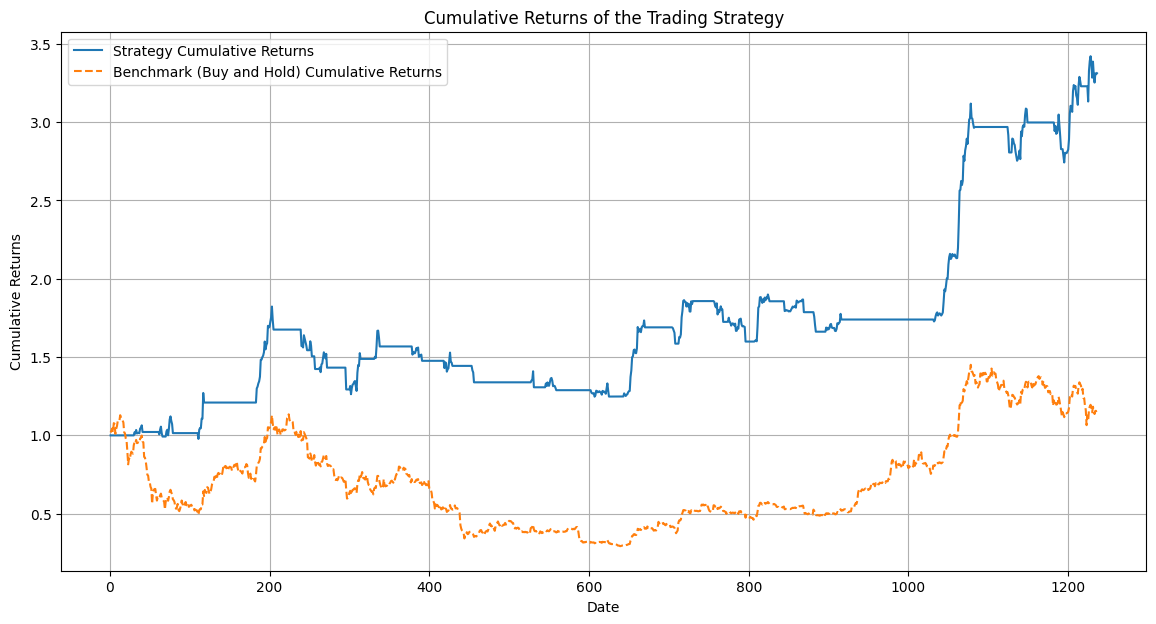

In [5]:
import matplotlib.pyplot as plt
# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(df['cumulative_returns2'], label='Strategy Cumulative Returns')
plt.plot(df['benchmark_returns'], label='Benchmark (Buy and Hold) Cumulative Returns', linestyle='--')
plt.title('Cumulative Returns of the Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
